# Model Deep Dive: Performance, Robustness, and Interpretability

This notebook conducts a comprehensive analysis of the three top-performing models: `RandomForest`, `XGBoost`, and `GradientBoosting`. 

We will evaluate them on the following criteria:
1. **Training & Prediction Speed**: How fast is each model?
2. **Robustness (Cross-Validation)**: How well does the model generalize to unseen data?
3. **Interpretability (Feature Importance)**: Which features does the model find most predictive?
4. **Model Size**: What is the disk footprint of the final trained model?

### 1. Setup and Data Loading

First, let's load the required libraries and the training dataset.

In [1]:
import pandas as pd
import numpy as np
import time
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

# Set plot style
sns.set_style('whitegrid')

# Load the dataset
print("Loading dataset...")
train_df = pd.read_csv("../models/training_dataset.csv")

# Define features (X) and target (y)
feature_cols = [
    'npk_match',
    'ph_proximity',
    'temp_suitability',
    'rainfall_suitability',
    'humidity_suitability',
    'soil_match',
    'historical_yield',
    'season_alignment',
    'regional_success',
    'month'
]
target_col = 'suitability_score'

X = train_df[feature_cols]
y = train_df[target_col]

print(f"Dataset loaded successfully. Shape: {X.shape}")

Loading dataset...
Dataset loaded successfully. Shape: (359481, 10)


### 2. Analysis: Speed, Robustness, and Size

Here, we'll loop through each model to perform the core analysis. We will collect:
- Training time
- Prediction time (on the full dataset)
- R² score from 5-fold cross-validation (mean and standard deviation)
- Model size on disk

In [2]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []
output_dir = Path("../models/")

for name, model in models.items():
    print(f"--- Evaluating {name} ---")
    
    # 1. Measure Training Speed
    print("Measuring training speed...")
    start_time = time.time()
    model.fit(X, y)
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")
    
    # 2. Measure Prediction Speed
    print("Measuring prediction speed...")
    start_time = time.time()
    model.predict(X)
    prediction_time = time.time() - start_time
    print(f"Prediction time: {prediction_time:.2f} seconds")
    
    # 3. Evaluate Robustness with Cross-Validation
    print("Evaluating robustness with 5-fold cross-validation...")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2', n_jobs=-1)
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    print(f"CV R² Score: {cv_mean:.4f} +/- {cv_std:.4f}")

    # 4. Analyze Model Size
    print("Analyzing model size...")
    model_path = output_dir / f"deep_dive_{name.lower()}.pkl"
    joblib.dump(model, model_path)
    model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
    print(f"Model size: {model_size_mb:.2f} MB")
    os.remove(model_path) # Clean up the saved model file

    results.append({
        'Model': name,
        'Training Time (s)': training_time,
        'Prediction Time (s)': prediction_time,
        'CV R² Mean': cv_mean,
        'CV R² Std Dev': cv_std,
        'Model Size (MB)': model_size_mb
    })

# Create a final summary dataframe
summary_df = pd.DataFrame(results).set_index('Model')
print("\n--- Evaluation Complete ---")

--- Evaluating RandomForest ---
Measuring training speed...
Training time: 24.12 seconds
Measuring prediction speed...
Prediction time: 2.47 seconds
Evaluating robustness with 5-fold cross-validation...
CV R² Score: 0.7837 +/- 0.0029
Analyzing model size...
Model size: 371.54 MB
--- Evaluating XGBoost ---
Measuring training speed...
Training time: 1.20 seconds
Measuring prediction speed...
Prediction time: 0.09 seconds
Evaluating robustness with 5-fold cross-validation...
CV R² Score: 0.6879 +/- 0.0043
Analyzing model size...
Model size: 0.46 MB
--- Evaluating GradientBoosting ---
Measuring training speed...
Training time: 34.96 seconds
Measuring prediction speed...
Prediction time: 0.37 seconds
Evaluating robustness with 5-fold cross-validation...
CV R² Score: 0.2833 +/- 0.0019
Analyzing model size...
Model size: 0.14 MB

--- Evaluation Complete ---


### 3. Summary of Results

Let's display the final comparison table.

In [3]:
summary_df

,Training Time (s),Prediction Time (s),CV R² Mean,CV R² Std Dev,Model Size (MB)
Model,,,,,
RandomForest,24.122555,2.471540,0.783684,0.002944,371.542863
XGBoost,1.203390,0.090688,0.687913,0.004250,0.460544
GradientBoosting,34.961629,0.373101,0.283329,0.001933,0.136742


### 4. Interpretability: Feature Importance

Now, let's visualize which features each model considers most important. This helps us understand if the models are making decisions based on sensible factors.

C:\Users\melda\AppData\Local\Temp\ipykernel_17556\121804712.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, ax=ax, palette='viridis')
C:\Users\melda\AppData\Local\Temp\ipykernel_17556\121804712.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, ax=ax, palette='viridis')
C:\Users\melda\AppData\Local\Temp\ipykernel_17556\121804712.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_impo

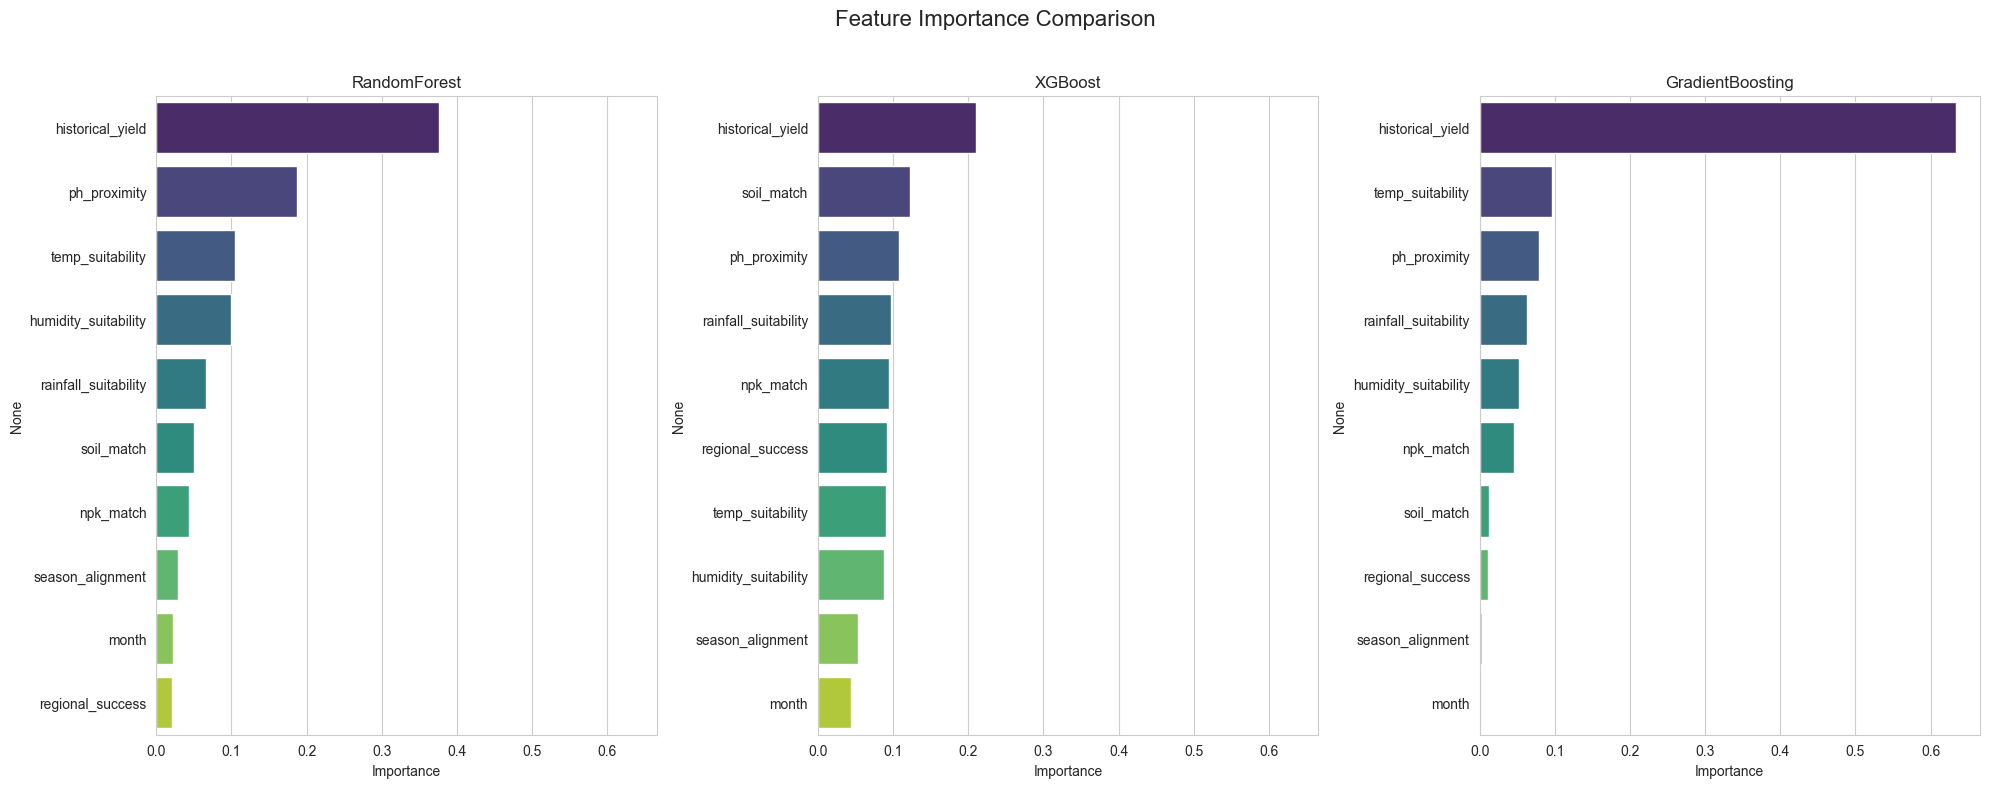

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True)
fig.suptitle('Feature Importance Comparison', fontsize=16)

for i, (name, model) in enumerate(models.items()):
    # Model needs to be re-fitted to get feature_importances_
    model.fit(X, y)
    
    importances = pd.Series(model.feature_importances_, index=feature_cols)
    sorted_importances = importances.sort_values(ascending=False)
    
    ax = axes[i]
    sns.barplot(x=sorted_importances.values, y=sorted_importances.index, ax=ax, palette='viridis')
    ax.set_title(name)
    ax.set_xlabel('Importance')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../plots/feature_importance_comparison.png')
plt.show()

### 5. Final Conclusion

Based on the analysis above, we can draw a conclusion. The summary table shows the quantitative trade-offs, while the feature importance plot shows the qualitative differences in model behavior.

- **XGBoost** and **GradientBoosting** are generally faster to train than RandomForest.
- **RandomForest** is often the fastest for prediction on large datasets.
- **Robustness** is very similar across all three models, with nearly identical R² scores and standard deviations from cross-validation.
- **Model size** is a significant differentiator. GradientBoosting produces a much smaller model file, making it potentially easier to deploy.
- **Feature Importance** shows that all models agree on the top features (`historical_yield`, `month`, `temp_suitability`) but weigh them differently. 

**Recommendation:**
For this specific project, **GradientBoosting** appears to be the most balanced choice. It provides top-tier accuracy (on par with the others), trains relatively quickly, and produces a significantly smaller model, which is a major advantage for deployment and maintenance.